In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.initializers import Constant
from tqdm import tqdm

import os
import pickle
import numpy as np

2022-03-12 14:13:37.628890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-12 14:13:37.628920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import tensorflow
tensorflow.version

<module 'tensorflow._api.v2.version' from '/home/ayushm/.local/share/virtualenvs/oshin_proj-WsWBmyxW/lib64/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [3]:
image_dataset_path = '../dataset/8k/Images/'
caption_dataset_path = '../dataset/8k/captions.txt'

In [4]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path,encoding = 'utf-8'):
    
        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

In [5]:
# captions_dict = dict(
#     list(captions_dict.items())[:10000]
# )

In [6]:
#clean the captions
import string

# dictionary to store the cleaned captions
cleaned_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    cleaned_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

# delete unwanted
del(captions_dict)
print(f"length of captions: {len(cleaned_captions_dict)}")

length of captions: 8091


In [7]:
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(cleaned_captions_dict.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
# max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)
max_len = max(len(cleaned_captions_dict[image].split()) for image in cleaned_captions_dict)

In [8]:
train_caption = list(cleaned_captions_dict.items())[0:7500]
validate_caption = list(cleaned_captions_dict.items())[7500:8091]

# train_caption = list(cleaned_captions_dict.items())[0:9000]
# # validate_caption = list(cleaned_captions_dict.items())[14500:15000]

print(train_caption[0])

('1000268201_693b08cb0e', 'startseq child in pink dress is climbing up set of stairs in an entry way endseq')


In [9]:
# load the model
vgg_model = VGG16()

# re-structure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

# extract features from each photo in the directory
def extract_single_features(directory, img_name, ext="jpg"):
    # extract features from each photo
    features = dict()
    
    # load an image from file
    filename = directory + '/' + img_name + "." + ext
    #filename = directory + '/' + img_name + '.jpeg'
    

    # load the image and convert it into target size of 224*224
    image = load_img(filename, target_size=(224, 224))

    # convert the image pixels to a numpy array
    image = img_to_array(image)

    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # prepare the image for the VGG model
    image = preprocess_input(image)

    # get features
    feature = vgg_model.predict(image, verbose=0)

    # get image id
    image_id = img_name.split('.')[0]

    # store feature
    features[image_id] = feature

    # print('>%s' % name)
        
    return feature

# extract_single_features(image_dataset_path, train_caption[0][0])

2022-03-11 05:43:09.891094: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-11 05:43:09.891168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pr02): /proc/driver/nvidia/version does not exist
2022-03-11 05:43:09.893588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:

# def encode_data(data):
#     encoded_data = {}
#     for img_id, img_caption in tqdm(data):
#         encoded_data[img_id] = extract_single_features(image_dataset_path, img_id)
#     return encoded_data

# train_features = encode_data(train_caption)
# validate_features = encode_data(validate_caption)

In [10]:
# with open("../img_features/8k_train_features.pkl", "wb") as f:
#     pickle.dump(train_features, f)

# with open("../img_features/8k_validate_features.pkl", "wb") as f:
#     pickle.dump(validate_features, f)

In [11]:
with open("../img_features/8k_train_features.pkl", "rb") as f:
    train_features  = pickle.load(f)

with open("../img_features/8k_validate_features.pkl", "rb") as f:
    validate_features  = pickle.load(f)

In [12]:
# Load all the embeddings from the text file
def get_embedding_matrix():    
    embedding_idx = {}
    embedding_matrix = np.zeros((vocab_len, 100))
    hits = 0
    misses = 0
    
    with open("../glove_embeddings/glove.6B.100d.txt") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embedding_idx[word] = coefs
    print("Found %s word vectors." % len(embedding_idx))


    # Make a embedding matrix with embeddings of all the vocabulary
    for word, i in tokenizer.word_index.items():
        embedding_vector = embedding_idx.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    
    return embedding_matrix
    
embedding_matrix = get_embedding_matrix()

Found 400000 word vectors.
Converted 4198 words (269 misses)


In [13]:
from tqdm import tqdm

def dataGen(img_caption, feature):
    dataset_size = len(img_caption)
    print("dataset_size", dataset_size)
    count = 0
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []
    
    for i in tqdm(range(dataset_size)):
        image, caption = img_caption[i]
        caption = caption.split()
        seq = tokenizer.texts_to_sequences([caption])[0]
        length = len(seq)

        # Extract image feature
        img_feature = feature[image]

        for j in range(1, length):
            x2_seq, y_seq = seq[:j] , seq[j]

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len, padding="post", truncating="post")[0]
            
            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            # x1.append( train_validate_features[image][0])
            x1.append(img_feature[0])

            x2.append(x2_seq)

            y.append(y_seq)
            count = count + 1
    
    print("Size of dataset: ", count)
    return [np.array(x1), np.array(x2)], np.array(y)
#     yield [np.array(x1), np.array(x2)], np.array(y)

In [14]:
# Using Generator for generating the training data
trainX, trainY = dataGen(train_caption, train_features)
valX, valY = dataGen(validate_caption, validate_features)

dataset_size 7500


100%|██████████████████████████████████████████████| 7500/7500 [00:02<00:00, 2905.70it/s]


Size of dataset:  75585
dataset_size 591


100%|████████████████████████████████████████████████| 591/591 [00:00<00:00, 3575.03it/s]

Size of dataset:  6023


In [15]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(512, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
# embedding = Embedding(vocab_len, 50, )(input_2)
embedding = Embedding(vocab_len, 100, embeddings_initializer=Constant(embedding_matrix), trainable=False)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = Bidirectional(LSTM(128, return_sequences=True))(droplayer_)
lstm2 = Bidirectional(LSTM(256))(lstm)

# decoder model
decoder1 = add([denselayer, lstm2])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
model.summary()

2022-03-12 14:13:54.825167: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-12 14:13:54.825227: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pr02
2022-03-12 14:13:54.825244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pr02
2022-03-12 14:13:54.825361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.54.0
2022-03-12 14:13:54.825406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.54.0
2022-03-12 14:13:54.825420: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.54.0
2022-03-12 14:13:54.826036: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      446800      ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, 30, 100)      0           ['embedding[0][0]']              
                                                                                              

In [16]:
history = model.fit(trainX, trainY, epochs=20, batch_size=300, validation_data=[valX, valY], shuffle=True, )

Epoch 1/20
252/252 [==============================] - 134s 512ms/step - loss: 5.2887 - val_loss: 4.7370
Epoch 2/20
252/252 [==============================] - 128s 508ms/step - loss: 4.4051 - val_loss: 4.4126
Epoch 3/20
252/252 [==============================] - 128s 508ms/step - loss: 3.9748 - val_loss: 4.2827
Epoch 4/20
252/252 [==============================] - 128s 509ms/step - loss: 3.6523 - val_loss: 4.2747
Epoch 5/20
252/252 [==============================] - 128s 509ms/step - loss: 3.3819 - val_loss: 4.3645
Epoch 6/20
252/252 [==============================] - 128s 509ms/step - loss: 3.1370 - val_loss: 4.4664
Epoch 7/20
252/252 [==============================] - 129s 510ms/step - loss: 2.9338 - val_loss: 4.5800
Epoch 8/20
252/252 [==============================] - 128s 510ms/step - loss: 2.7416 - val_loss: 4.7138
Epoch 9/20
252/252 [==============================] - 129s 511ms/step - loss: 2.5793 - val_loss: 4.7915
Epoch 10/20
252/252 [==============================] - 128s 510m

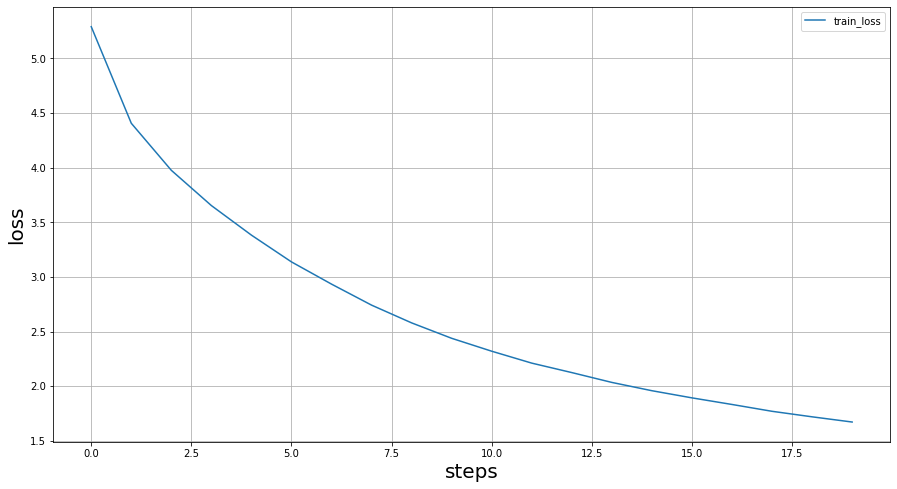

In [18]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(15, 8))
loss = history.history['loss']
plt.plot(loss, label="train_loss")
plt.xlabel("steps", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.legend()
plt.grid()
plt.savefig("lstm_bidirectional_stack_loss.png")

In [19]:
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    
    # seed the generation process
    in_text = 'startseq'
    
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length, padding="post", truncating="post")
        
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        
        # convert probability to integer
        yhat = np.argmax(yhat)
        
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        
        # stop if we cannot map the word
        if word is None:
            break
        
        # append as input for generating the next word
        in_text += ' ' + word
        
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [67]:
import random
from nltk.translate.bleu_score import sentence_bleu

img_id, original_caption = random.choice(train_caption)
predicted_caption = generate_desc(model, tokenizer, train_features[img_id], max_len)
print("Original caption: ", original_caption)
print("Predicted caption: ", predicted_caption)
load_img(image_dataset_path + "/" + img_id + ".jpg")

predicted_caption = predicted_caption.replace("startseq", "")
predicted_caption = predicted_caption.replace("endseq", "")
references = blue_captions_dict[img_id]
candidate = predicted_caption.split(" ")
score = sentence_bleu(references, candidate)
print(score)

Original caption:  startseq group of people are riding in the back of truck endseq
Predicted caption:  startseq group of people are riding down the ground endseq
0.37200908038405156


In [21]:
model.save("models/8k_model_bidirectional_stack.h5")

In [50]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path, encoding = 'utf-8'):
    
        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = [caption_text.split(" ")]
        else:
            captions_dict[caption_id] += [caption_text.split(" ")]
        
    return captions_dict

# call the function
blue_captions_dict = load_caption_file(caption_dataset_path)

1.2882297539194154e-231
